In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [71]:
# read in data file
df = pd.read_csv('playlist_revision_v02.txt', delimiter = "\t")

In [72]:
## Data has 403,366 playlists and has 25 columns of data
df.shape

(403366, 25)

In [122]:
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,owner_num_playlists,monthly_self_streams_30s
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,...,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber,2,0.900000
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,...,94,"[""good"", ""living""]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant,1,0.839286
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,...,0,"[""norteña""]",Latin,-,-,Lively,Upbeat,Romantic,2,0.000000
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,...,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant,3,0.701299
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,...,0,"[""cheesy"", ""pants""]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning,1,0.000000


In [74]:
# check data for any null values
df.isnull().sum()

# no nulls in the data

playlist_uri               0
owner                      0
streams                    0
stream30s                  0
dau                        0
wau                        0
mau                        0
mau_previous_month         0
mau_both_months            0
users                      0
skippers                   0
owner_country              0
n_tracks                   0
n_local_tracks             0
n_artists                  0
n_albums                   0
monthly_stream30s          0
monthly_owner_stream30s    0
tokens                     0
genre_1                    0
genre_2                    0
genre_3                    0
mood_1                     0
mood_2                     0
mood_3                     0
dtype: int64

In [75]:
## New Column Creation

## Find the number of playlists owned by user
df['owner_num_playlists'] = df.groupby('owner').owner.transform('count')

## Find the proportion of streams from owner (monthly_owner_stream30s/monthly_stream30s)
df['monthly_self_streams_30s'] = df['monthly_owner_stream30s'] / df['monthly_stream30s']

In [93]:
## Convert categorical variables to dummy variables
df_dummies = pd.get_dummies(df[['genre_1','genre_2','genre_3'
                                ,'mood_1','mood_2','mood_3' ]])

## Combine dummy variables to main df
df_main = pd.concat([df,df_dummies], axis =1)

In [99]:
## Spotify owns 399 playtlists - We'll want to remove these from any analysis as they would introduce outliers 
## since Spotify can control the exposure of their own playlists.

df_main[['owner', 'owner_num_playlists']].drop_duplicates().sort_values(by = 'owner_num_playlists', ascending = False)

,owner,owner_num_playlists
29,spotify,399
1451,6987037f34b5cee787a1a5e8de9b2689,48
16375,a5add6d0d5fbebb01abb2fbe7e47208d,47
6730,f54f32d1c706754a70f8392aa1dbad46,44
2154,4a03268bef1505a49f8b3eced879f311,43
...,...,...
139666,8b50775af2843b1ce30307b17d306527,1
139667,aa73a2cd968820987ad191c2245ac1c6,1
139671,c6bb73330724c6cd84dc4ecd78bea9f4,1
139672,491a8ba29147a865ca298f285d513a9b,1


In [119]:
### Outlier removal

### Remove using IQR
# Q1 = df['monthly_stream30s'].quantile(0.25)
# Q3 = df['monthly_stream30s'].quantile(0.75)
# IQR = Q3 - Q1

# # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
# filtered_data_outliers = df.query('(@Q1 - 1.5 * @IQR) <= monthly_stream30s <= (@Q3 + 1.5 * @IQR)')
# # excluded = df.query('monthly_stream30s >= (@Q3 + 1.5 * @IQR)')


## Remove and playlists outside of the 95th percentile
df_no_spotify = df_main.query('monthly_owner_stream30s < monthly_owner_stream30s.quantile(.99)')
df_no_spotify = df_no_spotify[df_no_spotify["owner"]!="spotify"]

In [116]:
## Create a function that will take in 2 variables and plot them with a line of best fit. 
## Must include axis labels and chart title

def plotter(x, y, x_lab, y_lab, chart_title):
    table = df_no_spotify.groupby(x)[y].mean().reset_index().sort_values(x,ascending = True)
    p = sns.regplot(table[x],table[y], ci=None)
    p.set(xlabel = x_lab, ylabel = y_lab, title = chart_title)

In [15]:
# check number of unique values in each column
for i in list(df.columns):
    print(f'Unique values in {i}: {df[i].nunique()}')

Unique values in playlist_uri: 403366
Unique values in owner: 314899
Unique values in streams: 1639
Unique values in stream30s: 1329
Unique values in dau: 566
Unique values in wau: 1019
Unique values in mau: 1597
Unique values in mau_previous_month: 1552
Unique values in mau_both_months: 765
Unique values in users: 2293
Unique values in skippers: 522
Unique values in owner_country: 1
Unique values in n_tracks: 4134
Unique values in n_local_tracks: 576
Unique values in n_artists: 1560
Unique values in n_albums: 1621
Unique values in monthly_stream30s: 6094
Unique values in monthly_owner_stream30s: 2418
Unique values in tokens: 192095
Unique values in genre_1: 26
Unique values in genre_2: 26
Unique values in genre_3: 26
Unique values in mood_1: 27
Unique values in mood_2: 27
Unique values in mood_3: 27


In [17]:
# check column types
df.dtypes

playlist_uri               object
owner                      object
streams                     int64
stream30s                   int64
dau                         int64
wau                         int64
mau                         int64
mau_previous_month          int64
mau_both_months             int64
users                       int64
skippers                    int64
owner_country              object
n_tracks                    int64
n_local_tracks              int64
n_artists                   int64
n_albums                    int64
monthly_stream30s           int64
monthly_owner_stream30s     int64
tokens                     object
genre_1                    object
genre_2                    object
genre_3                    object
mood_1                     object
mood_2                     object
mood_3                     object
dtype: object

### Presentation Set Up
#### Options
* Short term options - DAU/WAU/streams30
* Long term options - MAU/monthly_owner_stream30s/monthly_stream30s

#### Considerations
* need to balance short term and long term. DAU and WAU might have too much noise depending on people's lives. MAU is a much smoother metric

#### Goal of playlists
* Maximize listening time
* Assumption is that playlists are usually created by the user, and usually for the user.
* Check this by creating a histogram of users per playlist - most should have on avg 1 user

#### Selection
* Land on 30 days MAU
* Success of a metric is the number of streams it gets overtime, not important if its from the owner or not




### Data Preparation

#### New data to create
* Proportion of streams from owner (monthly_owner_stream30s/monthly_stream30s) 
* Number of playlists created by the owner (Assign count of user playlists per row)

#### Cleaning the data
* Kill Spotify made playlists (can introduce outliers to the data), Spotify playlists can be promoted to users
* Convert categorical variable to dummy variables (genre, mood)
* Watch out for/drop nulls

#### Data Visualization
Some combination of the following:
* Histogram of number of tracks in playlists 
* Relationship between Number of tracks in playlist <> 30 days MAU
* Histogram of number of albums in playlist 
* Relationship between num albums in playlist <> 30 days MAU  
* Histogram of genres 
* Relationship of genre <> 30 days MAU 
* Histogram of number of artists in playlists
* Relationship of number of artists in playlists <> 30 days MAU  
* Histogram of moods of playlist 
* Relationship of moods <> 30 days MAU 

Using these, there will probably be strong correlations but we can't determine causation yet. We'll move to a linear regression to help determine predicting

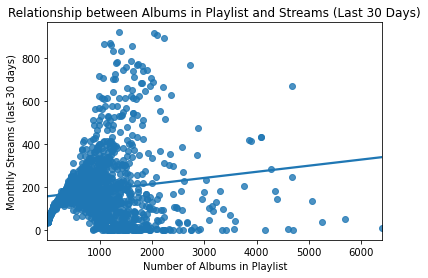

In [120]:
plotter(x = "n_albums"
        ,y = "monthly_owner_stream30s"
        ,x_lab = "Number of Albums in Playlist"
        ,y_lab = "Monthly Streams (last 30 days)"
        ,chart_title = "Relationship between Albums in Playlist and Streams (Last 30 Days)"
       )

### Regression
* Run linear regression
* Prune
* Answer and recommendation

### Next steps:
* What I would do next
    * Try more models
    * Gather/create more data fields

* [Insert Recommendation] and Run an A/B test to determine if we see a meaningful difference in MAU 30

## Archive

In [ ]:
# plt.scatter( wau_num_tracks.n_albums,wau_num_tracks.monthly_stream30s, color = "green")
# plt.title("AVG Weekly Active Users to Number of Tracks in Playlist")
# plt.xlabel("Number Tracks in Playlist")
# plt.ylabel("AVG WAU")
# plt.tight_layout()
# plt.show()